In [5]:
import pandas as pd

## User Parameter

In [6]:
file = "015_NTJJ03_dVdI_vs_(By)_sweep_some_Bz__I_2_3_V_9_8_ac5uA_13.33Hz_dcpre500x.dat"
mag_noise = 4e-5 # Noise in magnetic field
number_of_plots = 10
b_precision_legend = 3

resistance = 100000

skip_data_points = True

current_min = 0
current_max = 10

b_min = 0
b_max = 1000

dI_dV_min = 0
dI_dV_max = 20000

fig_a_name = "fig A.png"
fig_a_xlabel = "Magnetic Field (mT)"
fig_a_ylabel = r"I ($\mu$A)"

fig_b_name = "fig B.png"
fig_b_xlabel = "Current (mA)"
fig_b_ylabel = r"dV/dI ($\Omega$)"


### Reading the Data

#### Excluding all the lines where header exist

In [7]:
exclude = [i for i, line in enumerate(open(file)) if line.startswith('M')] 


In [37]:
data = pd.read_csv(file, sep="\t", skiprows= exclude[1:])
data

,Stable Magnetic Field (T),Sweeping Magnetic Field (T),Time (s),Vx (V),Vy (V),Ix (A),Iy (A),Rx (ohm)
0,-0.000013,-0.0300,13.3,0.00159,-135.0,0.000005,-135.0,315.0
1,0.000007,-0.0300,13.5,0.00159,-135.0,0.000005,-135.0,315.0
2,0.000016,-0.0300,13.7,0.00159,-135.0,0.000005,-135.0,315.0
3,-0.000014,-0.0300,13.8,0.00159,-135.0,0.000005,-135.0,315.0
4,-0.000002,-0.0300,14.0,0.00159,-135.0,0.000005,-135.0,315.0
...,...,...,...,...,...,...,...,...
266607,0.072000,0.0299,34400.0,0.00158,-135.0,0.000005,-135.0,314.0
266608,0.072000,0.0299,34400.0,0.00158,-135.0,0.000005,-135.0,314.0
266609,0.072000,0.0299,34400.0,0.00158,-135.0,0.000005,-135.0,314.0
266610,0.072000,0.0299,34400.0,0.00158,-135.0,0.000005,-135.0,314.0


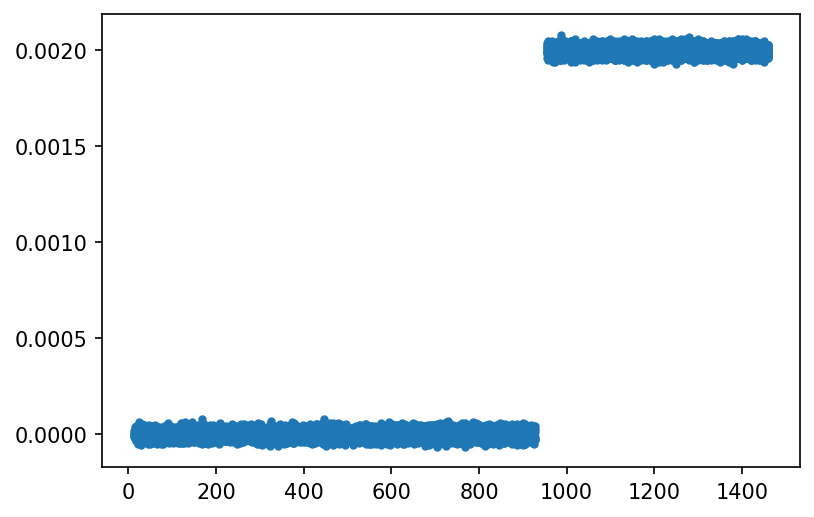

In [38]:
import matplotlib.pyplot as plt
num_points = 10000
fig, ax = plt.subplots()
ax.plot(data["Time (s)"][0:num_points], data["Stable Magnetic Field (T)"][0:num_points], ".")

### Split data into two datasets

In [39]:
import numpy as np
gradient_array = np.gradient(data["Sweeping Magnetic Field (T)"])
data = data[pd.Series(gradient_array) >= 0]
data.reset_index(drop=True, level=0, inplace=True)

for row in data.iterrows():
    
    

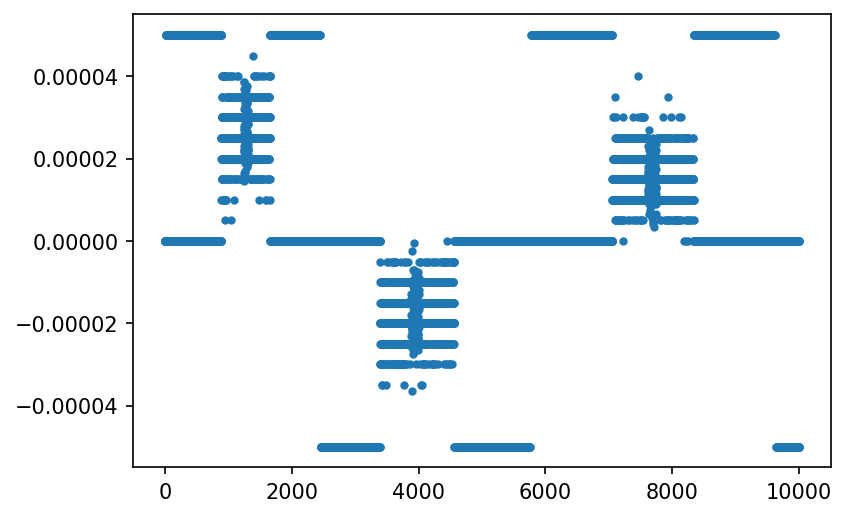

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
mpl.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()
ax.plot(data['Sweeping Magnetic Field (T)'].values[0:1000], ".")

### Dividing the dataframes into an array of dataframes with different magnetic field

In [8]:
def get_next_data_frame(dataframe, start, noise, axis=0 ):
    return dataframe[(dataframe[axis] < dataframe[axis][start] + noise) & (dataframe[axis] > dataframe[axis][start] - noise)]

In [9]:
def get_dataframes_by_column(dataframe, noise, axis):
    dataframes = []
    size = dataframe.first_valid_index()
    while(True):
        df = get_next_data_frame(dataframe, size, noise, axis)
        dataframes.append(df)
        size += df[axis].size
        if (size >= data[axis].size or (dataframe[axis][size] < dataframe[axis].values[-1] + noise) and (dataframe[axis][size] > dataframe[axis].values[-1] - noise)):
            return dataframes
    


### Saving each df into csv file

In [10]:
dataframes = get_dataframes_by_column(data, mag_noise, "Magnetic Field (T)")
# for i, df in enumerate(dataframes):
#     df.to_csv(f"{file}_{i}", sep="\t")

## Plot B

<ipython-input-11-26e5de95a4ad>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


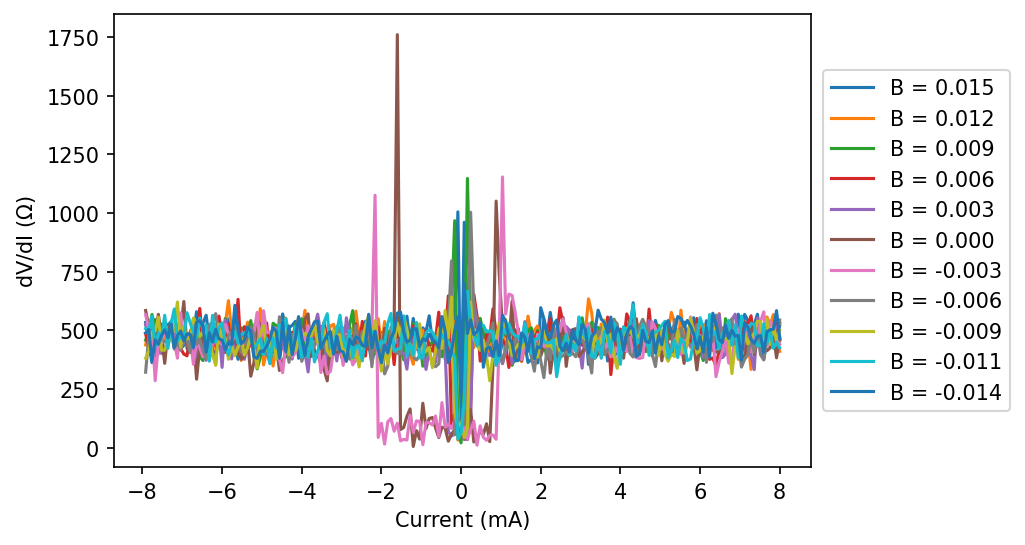

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()

divisor = len(dataframes) // number_of_plots
b_array = []
di_dv_array = []
first_df = dataframes[0]
for i, df in enumerate(dataframes):
    B = df["Magnetic Field (T)"].values[0]
    if (np.array(df["Differential Resistance dV/dI (ohm)"].values).shape ==  np.array(first_df["Differential Resistance dV/dI (ohm)"].values).shape):
        b_array.append(B)
        i_array = df["Source Voltage (V)"].values
        di_dv_column = np.array(df["Differential Resistance dV/dI (ohm)"].values)
        di_dv_column = di_dv_column / (np.amax(di_dv_column))
        di_dv_array.append(di_dv_column)
#     print(np.array(df["Differential Resistance dV/dI (ohm)"].values).shape)
    
    if (i% divisor == 0):
        ax.plot(df["Source Voltage (V)"], df["Differential Resistance dV/dI (ohm)"], "-", label = f"B = {B:.{b_precision_legend}f}")
ax.set_xlabel(fig_b_xlabel)
ax.set_ylabel(fig_b_ylabel)

legend = ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5) )
fig.savefig(fig_b_name, dpi = 300, bbox_extra_artists=(legend,),
            bbox_inches='tight')
fig.show()

## Plot A

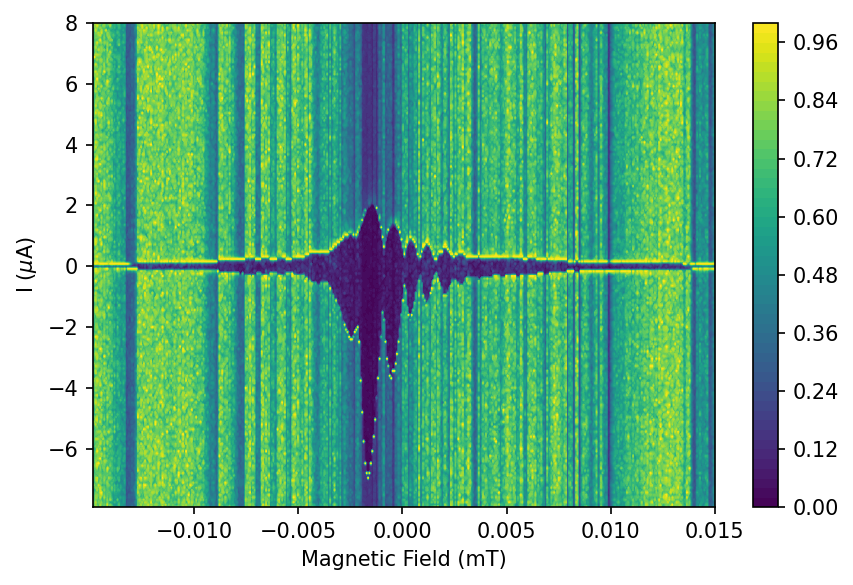

In [18]:
import numpy as np
from matplotlib import ticker, cm
fig, ax = plt.subplots()
cs = ax.contourf(b_array, list(i_array),  np.transpose(di_dv_array), levels=50, cmap="viridis" )
cbar = fig.colorbar(cs)
ax.set_xlabel(fig_a_xlabel)
ax.set_ylabel(fig_a_ylabel)
fig.tight_layout()
fig.savefig(fig_a_name, dpi = 600)


plt.show()

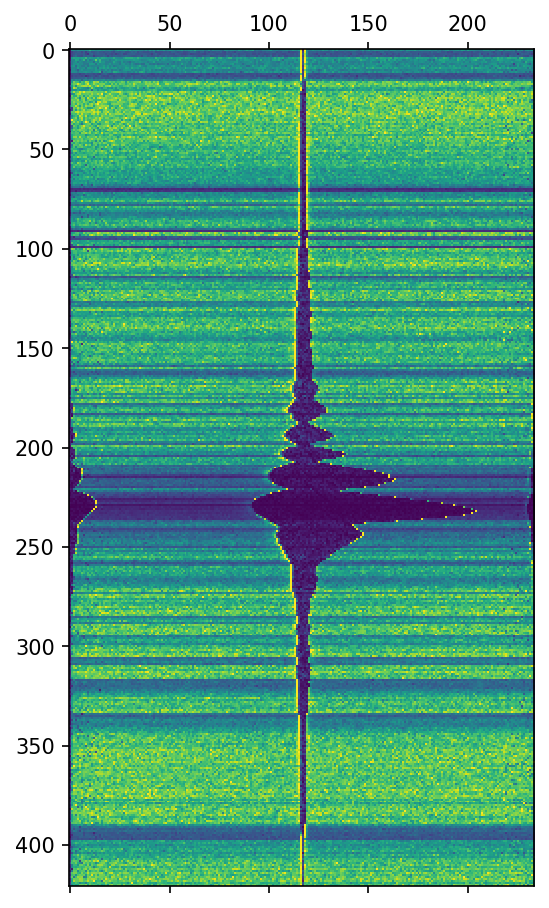

In [11]:
import matplotlib.pyplot as plt
import numpy as np


plt.matshow(di_dv_array)

plt.show()

In [54]:
print(np.array(di_dv_array).shape)
print("Shape of 1st arrays", di_dv_array[0].shape)
for i in range(len(di_dv_array)):
    if (di_dv_array[i].shape !=  di_dv_array[0].shape):
        print(i)
        print(di_dv_array[i].shape)


(428,)
Shape of 1st arrays (234,)
1
(242,)
34
(235,)
168
(235,)
169
(235,)
204
(235,)
207
(235,)
331
(235,)


In [41]:
print(b_array)

[0.01501045, 0.009674447, -0.01089028]


In [309]:
z_data = pd.DataFrame(np.transpose(di_dv_array))

In [311]:
z_data.to_csv("Matrix.dat", sep = "\t")

In [312]:
i_array = pd.DataFrame(i_array)

In [313]:
i_array.to_csv("Current Array.dat", sep = "\t")

In [314]:
b_array = pd.DataFrame(b_array)
b_array.to_csv("Mag Field Array.dat", sep = "\t")

In [389]:
x = np.array([np.array([1, 2, 3]), np.array([4, 5, 6])], np.int32)
x.shape

(2, 3)